# 3) Reconstruct target file with source collection frames

This is the final notebook of the Freesound AMPLAB session and contains the code that performs *audio mosaicing* to construct a new version of the target file by using audio frames chosen from the source collection. This notebook used the DataFrames generated in the previous notebooks which contain metadata about the Freesound sounds in the source collection, the analysis results of the source collection and the analysis results of the target audio file.

In [1]:
# Essentia
!pip install essentia
# Freesound-python
!pip install git+https://github.com/mtg/freesound-python.git
# Mount drive and cd to notebook folder
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Term2/ASMLab/Freesound/Self work'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mtg/freesound-python.git to /tmp/pip-req-build-h4mxu8ow
  Running command git clone --filter=blob:none --quiet https://github.com/mtg/freesound-python.git /tmp/pip-req-build-h4mxu8ow
  Resolved https://github.com/mtg/freesound-python.git to commit 14f2e6d35587181fb376f36fb2cfab4941c05b15
  Preparing metadata (setup.py) ... done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Term2/ASMLab/Freesound/Self work


In [2]:
import os
import pandas as pd
import essentia
import essentia.standard as estd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, Audio

In [3]:
# Load all DataFrames created in the previous notebooks
DATASET_FILENAME = 'dataframe.csv'
DATAFRAME_SOURCE_UNITS_FILENAME = 'dataframe_source.csv'
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'

df = pd.read_csv(open(DATASET_FILENAME), index_col=0)
df_source = pd.read_csv(open(DATAFRAME_SOURCE_UNITS_FILENAME), index_col=0)
df_target = pd.read_csv(open(DATAFRAME_TARGET_FILE_FILENAME), index_col=0)

In [4]:
features, features_frames = estd.MusicExtractor(lowlevelStats=['mean', 'stdev'],
                                              rhythmStats=['mean', 'stdev'],
                                              tonalStats=['mean', 'stdev'])('/content/drive/MyDrive/Term2/ASMLab/Freesound/Self work/files/109951_7037-hq.ogg')
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'metadata' not in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)
print(f'This subset contains {len(scalar_lowlevel_descriptors)} descriptors')

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

In [5]:
# Define some util functions
# NOTE: remember that if you update these util functions and want to do a new audio mosaicing, you'll need 
# to re-run both this cell (to update the util functions) and the cell below (which uses the util functions to
# do the audio mosaicing).

loaded_audio_files = {}
import random

def get_audio_file_segment(file_path, start_sample, n_samples):
    """Load audio file. Try to get it from memory first. If not there, open it and save in memory for next time.
    """
    if file_path not in loaded_audio_files:
        loader = estd.MonoLoader(filename=file_path)
        audio = loader()
        loaded_audio_files[file_path] = audio
    else:
        audio = loaded_audio_files[file_path]
        
    # Return segment
    return audio[start_sample:start_sample + n_samples]

def find_similar_frames(query_frame, df_source_frames, n, features):
    """Find the 'n' mosr similar frames for a given 'query_frame' from those in the given 'df_source_frames'.
    Similarity is computed using a nearest neighbours algorithm and taking only into account the feature list
    given in the 'features' parameter.
    """
    query_frame = query_frame.reshape(1,-1)
    nbrs = NearestNeighbors(n_neighbors=n, algorithm='ball_tree').fit(df_source_frames[features].values)
    distances, indices = nbrs.kneighbors(query_frame)
    return [df_source_frames.iloc[k] for k in indices[0]]

def chose_frame_from_source_collection(target_frame, df_source_frames):
    """Choose one frame from 'df_source_frames' to replace the 'target_frame'.
    This implementation chooses the source frame usinng a similarity algorithm 'find_similar_frames',
    and a specific set of similarity features for timbre (MFCC).
    You can modify this function to implement new ways to choose a frame from the source.
    
    NOTE: 'target_frame' here should have the same features as 'df_source_frames' because both the
    target file and the source collection have been analyzed with the same analysis function.
    You can list available features using 'print(list(target_frame.keys()))' and print(list(df_source_frames.keys()))
    """
    n_neighbours_to_find = 10
    similarity_features_tmp = ['mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12']  # Use MFCCs for sound similarity ['mfcc_0', 'mfcc_1']
    #print(similarity_features_tmp)
    #print(scalar_lowlevel_descriptors)
    similarity_features = similarity_features_tmp + scalar_lowlevel_descriptors
    #print(similarity_features)
    # Find the 10 most similar frames to the target_frame from df_source_framesdf_source_units 
    query_frame = target_frame[similarity_features].values
    similar_frames = find_similar_frames(query_frame, df_source_frames, n_neighbours_to_find, similarity_features)
    
    # Choose the first one as is the most similar
    most_similar_frame = random.choice(similar_frames)
    
    return most_similar_frame
    

In [6]:
# Do the reconstruction (audio mosaicing) of the target file using audio chunks (units, frames) from the sounds in the source collection

# Load target audio file to get its total length and to use it later
target_sound_filename = df_target.iloc[0]['path']
target_audio = estd.MonoLoader(filename=target_sound_filename)()
total_length_target_audio = len(target_audio)

# Init array where to put the audio of the reconstructed file
generated_audio = np.zeros(total_length_target_audio)

# Init list where to store IDs of sounds used in the reconstruction
selected_freesound_ids = []

# Iterate over the analyzed frame of the target file
print('Reconstructing audio file...')
for i in range(0, len(df_target)):
    if i%50 == 0:
      print(f"Doing the {i}'th frame over {len(df_target)} - {i/len(df_target)*100}%")
    target_frame = df_target.iloc[i]  # Get current frame
    
    # Choose one frame from the source collection to replace the target frame
    most_similar_frame = chose_frame_from_source_collection(target_frame, df_source)
    
    # Store freesound ID of the original sound where the 'most_similar_frame' belongs to
    selected_freesound_ids.append(most_similar_frame['freesound_id'])
    
    # Get the audio segment corresponding to the 'most_similar_frame'
    target_frame_n_samples = target_frame['end_sample'] - target_frame['start_sample']
    most_similar_frame_audio = get_audio_file_segment(most_similar_frame['path'], most_similar_frame['start_sample'],  target_frame_n_samples)
    
    # Add audio segment to the reconstructed audio array
    generated_audio[target_frame['start_sample']:target_frame['start_sample']+len(most_similar_frame_audio)] = most_similar_frame_audio

# Store the results in a WAV file
generated_audio_filename = '{0}.reconstructed.wav'.format(target_sound_filename)
estd.MonoWriter(filename=generated_audio_filename, format='wav', sampleRate=44100)(essentia.array(generated_audio))
print('Audio generated and saved in {0}!\nIt contains audio from the following sounds:'.format(generated_audio_filename))
display(df.loc[df['freesound_id'].isin(selected_freesound_ids)])  # Show metadata for the Freesound sounds used in the reconstruction


Reconstructing audio file...
Doing the 0'th frame over 1297 - 0.0%
Doing the 50'th frame over 1297 - 3.855050115651504%
Doing the 100'th frame over 1297 - 7.710100231303008%
Doing the 150'th frame over 1297 - 11.56515034695451%
Doing the 200'th frame over 1297 - 15.420200462606015%
Doing the 250'th frame over 1297 - 19.275250578257516%
Doing the 300'th frame over 1297 - 23.13030069390902%
Doing the 350'th frame over 1297 - 26.985350809560526%
Doing the 400'th frame over 1297 - 30.84040092521203%
Doing the 450'th frame over 1297 - 34.69545104086353%
Doing the 500'th frame over 1297 - 38.55050115651503%
Doing the 550'th frame over 1297 - 42.405551272166534%
Doing the 600'th frame over 1297 - 46.26060138781804%
Doing the 650'th frame over 1297 - 50.11565150346955%
Doing the 700'th frame over 1297 - 53.97070161912105%
Doing the 750'th frame over 1297 - 57.82575173477256%
Doing the 800'th frame over 1297 - 61.68080185042406%
Doing the 850'th frame over 1297 - 65.53585196607557%
Doing the 90

,name,username,license,tags,freesound_id,path
2,Piano drone.wav,robyn.levy323,http://creativecommons.org/publicdomain/zero/1.0/,"['heavily-edited', 'Piano', 'drone']",519226,files/519226_10964254-hq.ogg
3,Piano drone,laserlife,http://creativecommons.org/publicdomain/zero/1.0/,"['piano', 'drone', 'rock', 'post', 'ambient']",191167,files/191167_2372469-hq.ogg
4,Piano Drone,joelpless,http://creativecommons.org/publicdomain/zero/1.0/,"['atmosphere', 'mallet', 'spooky', 'deep', 'da...",215287,files/215287_1108574-hq.ogg
5,PianoDrone.wav,Accorman,http://creativecommons.org/publicdomain/zero/1.0/,"['stretch', 'ambient', 'granular', 'drone', 'g...",573799,files/573799_12922099-hq.ogg
6,HFDistPiano=.wav,hello_flowers,http://creativecommons.org/publicdomain/zero/1.0/,"['creepy', 'drone', 'line', 'muffled', 'piano']",28309,files/28309_199517-hq.ogg
...,...,...,...,...,...,...
84,Unknown Darkness 2,SergeQuadrado,https://creativecommons.org/licenses/by-nc/4.0/,"['starwars', 'starship', 'mission', 'science-f...",671334,files/671334_5479102-hq.ogg
86,Xylosoul - 2.wav,Phr4kture,http://creativecommons.org/publicdomain/zero/1.0/,"['melodic', 'wide', 'atmosphere', 'expansive',...",218567,files/218567_468390-hq.ogg
87,Ambient Synth Key (C Major),vanszisounddesign,http://creativecommons.org/publicdomain/zero/1.0/,"['space', 'keys', 'ambient', 'C-Major', 'synth...",435815,files/435815_6262563-hq.ogg
88,Swirly Synth Chord Loop,nlux,https://creativecommons.org/licenses/by/4.0/,"['atmos', 'atmosphere', 'atmospheric', 'relaxi...",620302,files/620302_9047165-hq.ogg


[516103, 547358, 541909, 613151, 428359, 519226, 424989, 354052, 348830, 354052, 582470, 223677, 223677, 424663, 348830, 424663, 348830, 547358, 348830, 608394, 608394, 426475, 547358, 424989, 541909, 608394, 78073, 78073, 553211, 506165, 426475, 654033, 582470, 386059, 535225, 553211, 553211, 547358, 553211, 386058, 519226, 613151, 426475, 519226, 582470, 582470, 426475, 608394, 582470, 223677, 223677, 535225, 608394, 348830, 223677, 348830, 414266, 223677, 424663, 354052, 426475, 223677, 582470, 582470, 582470, 519226, 424989, 553211, 348830, 654519, 424989, 613151, 386058, 608394, 424989, 553211, 608394, 608394, 613151, 553211, 223677, 424989, 608394, 506165, 613151, 582470, 408243, 348830, 424989, 424989, 354052, 424989, 608394, 71064, 608394, 608394, 223677, 354052, 519226, 78073, 386059, 348830, 348830, 354052, 424989, 223677, 535225, 408243, 354052, 424989, 506165, 582470, 426475, 71064, 354052, 519226, 541909, 535225, 71064, 582470, 572578, 608394, 424989, 529139, 354052, 71064

<BarContainer object of 81 artists>

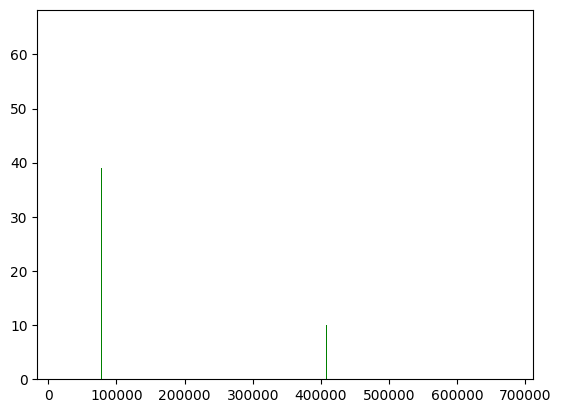

In [7]:
print(selected_freesound_ids)

print(len(selected_freesound_ids))

my_dict = {i:selected_freesound_ids.count(i) for i in selected_freesound_ids}

plt.bar(my_dict.keys(), my_dict.values(), 100, color='g')

In [ ]:
# Show further results of the reconstruction

# Plot waveforms
plt.figure(figsize=(15,5))
plt.plot(target_audio)
plt.axis([0, len(target_audio), -1, 1])
plt.title('Target audio')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(generated_audio)
plt.axis([0, len(target_audio), -1, 1])
plt.title('Reconstructed')
plt.show()

# Show audio players
print('Target audio')
display(Audio(target_audio, rate=44100))

print('Reconstructed')
display(Audio(generated_audio, rate=44100))

print('Mix of both signals')
display(Audio(generated_audio * 0.5 + target_audio * 0.5, rate=44100))

In [ ]:
display(Audio(target_audio[:44100*60*4+44100*59], rate=44100))

In [ ]:
display(Audio(generated_audio[:4410000], rate=44100))